State of affairs Dec 4:
    
    unclear why Marin/ other counties only have data starting in 2012. Confirmed for marin that the two
    pumas associated with it (which should be consistent 2010 for a decade), 4101 and 4102
    are not in the 2011 and 2012 household data files. the datafiles themselves are slihgly smaller
    in 2010, but not notably so 
    
153115 ss12hca_2012.csv
154324 ss14hca_2014.csv
154453 ss11hca_2011.csv
157734 psam_h06_2017.csv
156082 ss16hca_2016.csv
153589 ss13hca_2013.csv
159685 psam_h06_2018.csv
159756 psam_h06_2019.csv
145021 ss10hca_2010.csv
155218 ss15hca_2015.csv

need to at least catelouge how many aremisisng from the first two years, can flag as question 
for carolina. 

Results are not showing upward trend we were expecting, want to double check all data work 

otherwise, need to print out a chart of percent middle income over time for each county in cA

do charts for just top 10 MSAs

figure out what to do about (see total number missing at bottom) the smaller counties whose 
data is missing - maybe can do puma mapping?

otherwise finish and send our preliminary work. 

In [1]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import re 

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

#### Load in HUD AMI data 

In [152]:
# read in HUD AMI data downloaded for each year from here https://www.huduser.gov/portal/datasets/il.html#2010
path = "/Users/quinnunderriner/Desktop/Work/missing_middle/county_median_data/"
#path = os.getcwd()
df = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith("HUD-IL"):
        df_new = pd.read_csv(os.path.join(path, filename))
        df_new["year"] = filename[-8:-4]
        median_col = [x for x in df_new.columns if "median" in x]

        df_new = df_new.rename(columns={median_col[0]:"median"})

        columns = ["State_Alpha","County_Name","Metro_Area_Name","year","median"]
        df_new = df_new[columns]
        df = pd.concat([df,df_new],ignore_index=True)
df = df[df.State_Alpha =="CA"]#filter for california
#df.to_csv("california_hud_AMI_levels_2010-2019.csv")

#### Load in PUMS household Data

got data below from downloading these zips like below, will load in with code if time later to make neater 

for i in range_list:
    print("https://www2.census.gov/programs-surveys/acs/data/pums/"+i+"/1-Year/csv_hca.zip")

In [14]:
#PUMA - County Crosswalk - https://mcdc.missouri.edu/applications/geocorr2018.html.
#note, manually changed all one to many (PUMA->County) matchings to just be "Multiple CA".
#These are the small counties that are just a part of a PUMA and for the purpose of our analysis are combined 
crosswalk_df=pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

In [5]:
def read_in_PUMS(hpums_df,col_names):
    variable_types = {"NP":"int64","NOC":"float","BDSP":"float","RMSP":"str","MV":"float","WGTP":"float"}

    columns = ["SERIALNO","NP","R65","NRC","PUMA","RT","BDSP","BLD","RNTP","MRGP","SMP", "TYPE",
               "CONP","TEN","VACS","VALP","GRPIP","GRNTP","SMOCP","OCPIP","HINCP","MV","WGTP","NOC", "MULTG", 'YBL']


    hpums_df.rename(columns={"RT":"record_type",
                         "TYPE":"type",
                         "BLD":"units_in_structure",
                         "BDSP":"number_bedrooms",
                         "RNTP":"monthly_rent",
                         "MRGP":"first_mortgage",
                         "SMP":"second_mortgage",
                         "CONP":"condo_fee",
                         "TEN":"tenure",
                         "VACS":"vacancy_status",
                         "VALP":"property_value",
                         "GRPIP":"gross_rent_pct_of_income",
                         "GRNTP":"gross_rent",
                         "SMOCP":"select_owner_cost",
                         "OCPIP":"select_owner_cost_pct_of_income",
                         "HINCP":"hh_income",
                         "NP":"ppl_in_hh",
                         "R65":"ppl_over_65",
                         "NRC":"num_relate_chldrn",
                         "NOC":"num_own_chldrn",
                         "MULTG":"multi_gen_hh",
                         "WGTP":"weight",
                         "YBL": "year_built",
                         "MV":"moved_in"}, inplace=True)
    hpums_df.drop(hpums_df[hpums_df.type != 1].index, inplace=True)
    
    return hpums_df

Markdown cell because want to be rerunning file and easier to just load in output of below 
from a csv then wait for the below to run to run everytime. But this code takes the 2010-2019
PUMS household data, makes a year column, and then concat its together 

for filename in os.listdir(path_csv):
    df_new1 = pd.read_csv(os.path.join(path_csv, filename))
    df_new1= read_in_PUMS(df_new1,col_names)
    df_new1["year"] = filename[-8:-4] 
    hca = pd.concat([hca,df_new1],ignore_index=True)
pums_ca = hca.ST["6"]#added retroactively 

In [172]:
#load in output of above from CSV 
pums_ca = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/2010-2019_ca_household_survey.csv")
pums_sub_cols = ["County",'year',"hh_income","ppl_in_hh",'PUMA']#Took more cols just in case from big dataset above, but this is all we need for this calc 
pums_ca = pums_ca[pums_sub_cols]

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Do PUMA to County Crosswalk

Note: for years 2010 and 2011 the 2010 PUMA defintions were still being used; it was not until 2012 that the
    new definitions came into effect. Therefore need to map the 2010-2011 and 2012-2019 groups seperately. 

In [173]:
def gimmie_county(x):
    return x[0:x.find('County')]

def bring_in_crosswalk(df):
    crosswalk_df2010 = pd.read_excel("PUMA2000_PUMA2010_crosswalk.xls") # https://usa.ipums.org/usa/volii/pumas10.shtml#crosswalk
    crosswalk_df2010 = crosswalk_df2010[crosswalk_df2010.State10_Name =="California"]
    crosswalk_df2010 = crosswalk_df2010[["PUMA00","PUMA10","PUMA10_Name"]] #filter for datasetes we want 
    
    df_2010 = df[df.year.isin([2010,2011])] 
    
    df_2010 = df_2010.drop(columns={"County"}) #drop county col, was missing for these years, will re add below 
    
    pums_ca_2010 = df_2010.merge(crosswalk_df2010, how="left",left_on="PUMA",right_on="PUMA00")
    
    pums_ca_2010["County"] = pums_ca_2010.PUMA10_Name.apply(lambda x: gimmie_county(x))
    
    pums_ca_2010 = pums_ca_2010.drop(columns={"PUMA","PUMA00"})
    pums_ca_2010 = pums_ca_2010.rename(columns={"PUMA10":"PUMA"})#make new PUMA col the definitive PUMA col 
    
    pums_ca_2010 = pums_ca_2010[["year","hh_income","ppl_in_hh","County","PUMA"]]#keep only cols we want so we can concat 
    
    crosswalk_df2012 = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

    df_2012 = df[~df.year.isin([2010,2011])]

    puma_county_df_2012 = df.merge(crosswalk_df2012, how='left', on="PUMA")
    puma_county_df_2012['County'] = puma_county_df_2012['county1'].str.replace(r' CA', '')
    puma_county_df_2012.drop('county1', axis=1, inplace=True)
    
    puma_county_df_2012 = puma_county_df_2012[["year","hh_income","ppl_in_hh","County","PUMA"]]#keep only cols we want so we can concat 

    puma_county_df = pd.concat([pums_ca_2010, puma_county_df_2012], ignore_index=True) #concat both datasets back together now that they have the same columns 
    
    return puma_county_df

In [174]:
pums_ca = bring_in_crosswalk(pums_ca) #call function 

In [175]:
pums_ca = pums_ca.dropna() # we lose ~300k records for having null values 
# we lose another 7896 by getting rid of entries with bad types, acceptable error in a dataset this big 
pums_ca = pums_ca[pd.to_numeric(pums_ca['hh_income'], errors='coerce').notnull()]
pums_ca.hh_income = pums_ca.hh_income.astype(float) #convert to float so we can do calculations 

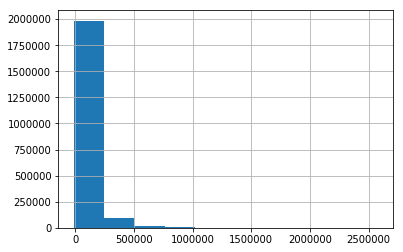

In [176]:
import matplotlib.pyplot as plt
#check for outliers in hh income 
pums_ca.hh_income.hist()

In [177]:
#in this dataset negative income doenst really make sense, so I'll drop those rows.
#Strange to see renter with 2.5 million income, but certainly not impossible in sf so can't
#assume data error. 
pums_ca.hh_income.describe()

count   2104477.00
mean      90445.28
std       98202.15
min      -15700.00
25%       30700.00
50%       63530.00
75%      114500.00
max     2580000.00
Name: hh_income, dtype: float64

In [178]:
pums_ca = pums_ca[pums_ca['hh_income'] >=0] #drop negative hh income  

Need to adjust median income figure for family size 

"Calculation of income limits for other family sizes is straight-forward. The 1-person family income limit is 70% of the 4-person income limit. The 2-person family income limit is 80% of the 4-person income limit, the 3-person family income limit is 90% of the 4-person income limit, the 5-person income limit is 108% of the 4-person income limit, the 6-person family income limit is 116% of the 4-person income limit, the 7-person family income limit is 124% of the 4-person income limit, and the 8-person family income limit is 132% of the 4-person income limit. For family sizes larger than 8 persons, the income limit can be calculated by adding an additional eight (8) percent per person to the next lower limit. For example a 9-person family income limit is 140% (132% + 8%), and so on. The resulting low-income limit calculation for other family sizes are then rounded up to the nearest $50 to produce the Final VLIL."

https://www.huduser.gov/portal/datasets/il/il2020/2020IlCalc.odn


In [179]:
#need to have household adjustments for up to size 20 
pums_ca.ppl_in_hh.value_counts()

2     666919
1     505353
3     339571
4     304312
5     157804
6      70477
7      29662
8      14229
9       6949
10      3698
11      1986
12      1334
13       404
14       254
15       129
16        61
20        48
17        32
19        15
18        13
Name: ppl_in_hh, dtype: int64

In [182]:
pums_ca.County = pums_ca.County.str.rstrip()

In [189]:
pums_ca.County.unique()

array(['Butte', 'Placer', 'Multiple', 'Los Angeles', 'Riverside', 'Yolo',
       'Contra Costa', 'San Mateo', 'Sacramento', 'San Joaquin',
       'San Bernardino', 'Orange', 'Kern', 'Tulare', 'Santa Barbara',
       'Ventura', 'Fresno', 'Monterey', 'El Dorado', 'Merced',
       'Santa Clara', 'Alameda', 'Stanislaus', 'Solano',
       'San Luis Obispo', 'Humboldt', 'San Francisco', 'San Diego',
       'Santa Cruz', 'Shasta', 'Sonoma', 'Kings', 'Marin', 'Imperial',
       'Napa', 'Madera'], dtype=object)

In [120]:
pums_ca.County = pums_ca.County.str.rstrip()#strip trailing white space 
pums_ca = pums_ca.replace({
    'County':{'Monterey (South & East) & San Benito Countie':"Multiple",
            'Nevada & Sierra Countie':"Multiple","Sutter & Yuba Counties--Yuba Cit":"Multiple",
            "Del Norte, Lassen, Modoc, Plumas & Siskiyou Countie":"Multiple",
            "Alpine, Amador, Calaveras, Inyo, Mariposa, Mono & Tuolumne Countie":"Multiple",
             'Colusa, Glenn, Tehama & Trinity Countie':"Multiple",
             "Lake & Mendocino Countie":"Multiple"}})#the 2010-2011 data did the one to many PUMA to County mapping, I'm just manually setting these to the Multiple category
pums_ca.County = pums_ca.County +" County" #make naming conventions align so can merge
pums_ca["key"] = pums_ca["County"] + pums_ca["year"].astype(str) #make keys to match on 
df["key"] = df["County_Name"] + df["year"].astype(str)

In [142]:
pums_ca.County.unique()

array(['St. Clair & Blount Countie County County',
       'Jefferson  County County',
       'Walker, Marion (South & West), Fayette & Lamar Countie County County',
       'Maricopa  County County',
       'Tucson (West) & Marana Citie County County',
       'Pima  County County',
       'Gila, Graham, Greenlee & Pinal (East) Countie County County',
       'Pinal  County County',
       'St. Francis, Poinsett, Phillips, Cross, Lee & Monroe Countie County County',
       'White, Jackson, Prairie & Woodruff Countie County County',
       'Faulkner & Lonoke Countie County County',
       'Jefferson, Grant & Arkansas (Northwest) Countie County County',
       'Butte  County County', 'Placer  County County',
       'Sutter & Yuba Counties--Yuba Cit County County',
       'Hartford Tow County County',
       'West Hartford, Farmington, Simsbury, Bloomfield, Avon & Canton Town County County',
       'Glastonbury, Newington, Wethersfield, Rocky Hill & Marlborough Town County County',
       'A

In [121]:
#need to create range of values for each county 
df["80%_AMI"] = df["median"] * 0.8
df["120%_AMI"] = df["median"] * 1.2

In [122]:
#merge data 
df_merged = pums_ca.merge(df,on="key",how="left")

In [123]:
pums_ca_count = pums_ca.groupby(["County","year"]).count().reset_index()[["County","year"]]

In [124]:
#Many counties, those listed with 8 below, are all missing 2010 and 2011 data. 
#From investigation it seems like the related PUMAs are missing from the PUMS data, not sure why
#note to quinn, scratch work for this in AMI_Bands_Main_file_Clean notebook 
pums_ca_count.County.value_counts()

Kings County                                                                             10
Multiple County                                                                          10
Fresno County                                                                            10
Contra Costa County                                                                      10
Sacramento County                                                                        10
                                                                                         ..
San Sebastián, Aguada, Moca, Añasco & Rincón Municipios--Carr 2-Carr 11 County County     2
Northwest Georgia Regional Commission (East Central)--Bartow  County County               2
Cameron  County County                                                                    2
North Texas Regional Planning Commission (Outside Wichita  County County                  2
Hamblen, Cocke & Grainger Countie County County                                 

In [125]:
# do some column clean up 
df_merged = df_merged.drop(columns={"year_x"})
df_merged = df_merged.rename(columns={"year_y":"year"})

In [126]:
#create AMI percentages from median number 
df_merged["80%_AMI"] = df_merged["median"] * 0.8
df_merged["120%_AMI"] = df_merged["median"] * 1.2

In [127]:
family_size_dict = {1:.7,
                   2:.8,
                   3:.9,
                   4:1,
                    5:1.08,
                    6:1.16,
                    7:1.24,
                    8:1.32,
                   9:1.40,
                   10:1.48,
                   11:1.56,
                   12:1.64,
                   13:1.72,
                   14:1.80,
                   15:1.88,
                   16:1.96,
                   17:2.04,
                   18:2.12,
                   19:2.20,
                   20:2.28}
#make new column of the AMI multiplier based on each households family size 
df_merged["family_size_multiplier"] = df_merged["ppl_in_hh"].map(family_size_dict)

In [128]:
#adjust ami bands for each household based on household size 
df_merged["80%_AMI_adjusted"] = df_merged["80%_AMI"] * df_merged["family_size_multiplier"]
df_merged["120%_AMI_adjusted"] = df_merged["120%_AMI"] * df_merged["family_size_multiplier"]

In [129]:
#want to label households in dataset that are middle income 
df_merged['middle_income_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] <= df_merged["120%_AMI_adjusted"]), 1, 0)

In [130]:
middle_income = df_merged[df_merged['middle_income_HH'] ==1]

In [131]:
# 17.2 percent of households in our dataset fall into this middle income category
len(middle_income)/len(df_merged) 

0.03677851908324548

In [132]:
#here i want to sum middle income houses for each year and county combo and then also get a total count for each 
#year and county combo, and make a small data frame with just this information. 
#then can calculate percentage of Middle income renters in each year and county through simple divison 
mid_income_count = df_merged.groupby(["year","County_Name"]).sum().reset_index()[["year","County_Name","middle_income_HH"]]
total_income_count = df_merged.groupby(["year","County_Name"]).count().reset_index()[["year","County_Name","middle_income_HH"]]
mid_income_count_percentage = mid_income_count.merge(total_income_count,on=["year","County_Name"])
mid_income_count_percentage = mid_income_count_percentage.rename(columns={"middle_income_HH_x":"middle_income_HH","middle_income_HH_y":"total"})
mid_income_count_percentage["Middle Income Renter Percentage"] = mid_income_count_percentage["middle_income_HH"] /mid_income_count_percentage["total"]

In [133]:
mid_income_count_percentage["Middle Income Renter Percentage"].describe()

count   302.00
mean      0.17
std       0.02
min       0.13
25%       0.17
50%       0.17
75%       0.18
max       0.25
Name: Middle Income Renter Percentage, dtype: float64

In [134]:
mid_income_count_percentage.County_Name.unique()

array(['Contra Costa County', 'El Dorado County', 'Fresno County',
       'Imperial County', 'Kings County', 'Los Angeles County',
       'Napa County', 'Placer County', 'Sacramento County',
       'San Francisco County', 'San Mateo County', 'Alameda County',
       'Butte County', 'Humboldt County', 'Kern County', 'Madera County',
       'Marin County', 'Merced County', 'Monterey County',
       'Orange County', 'Riverside County', 'San Bernardino County',
       'San Diego County', 'San Joaquin County', 'San Luis Obispo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

In [135]:
bay_area_counties = ["Alameda County",
"Contra Costa County",
"Marin County",
"Napa County",
"San Francisco County",
"San Mateo County",
"Santa Clara County",
"Solano County",
"Sonoma County"]
bay_area = mid_income_count_percentage[mid_income_count_percentage.County_Name.isin(bay_area_counties)]

#df = df[df['CSA'].isin(csa_filter)]

In [136]:
bay_area["key"] = bay_area["year"].astype(str) + bay_area["County_Name"]

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
alt.Chart(bay_area).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage',
    color="County_Name"
)

alt.Chart(...)

In [138]:
alt.Chart(sf_mid).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage'
)

NameError: name 'sf_mid' is not defined

In [ ]:
#need to address discrepency in number of counties - seems to be just smaller counties missing 
len(df.County_Name.unique()) - len(pums_ca.County.unique())

In [ ]:
#127 
set(df.County_Name.unique()).difference(set(pums_ca.County.unique()))

In [ ]:
pums_ca.County.unique()